# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Import

In [110]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torch.functional import F
from torchvision import transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


import pandas as pd
import numpy as np
import os
from PIL import Image

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data

In [111]:
with open('iam_words/words.txt', 'r') as f:
    words = f.readlines()
words = [word.strip() for word in words]
words = words[18:-1]
words = [w for w in words if ' err ' not in w]
words = [[w.split(' ')[0], w.split(' ')[-1]] for w in words]
words = [
    [f'iam_words/words/{w.split('-')[0]}/{w.split('-')[0]}-{w.split('-')[1]}/{w}.png', y] for w, y in words]
df = pd.DataFrame(words, columns=['filename', 'word'])
df = df[df['filename'].apply(os.path.exists)]
# Filter out rows where the file cannot be opened
# valid_rows = []
# for _, row in df.iterrows():
#     try:
#         with Image.open(row['filename']) as img:
#             img.verify()  # Verify that the file is a valid image
#         valid_rows.append(row)
#     except Exception as e:
#         print(f"Skipping file {row['filename']} due to error: {e}")

# df = pd.DataFrame(valid_rows, columns=df.columns)
vocab = ''.join(sorted(set(''.join(df['word'].values))))
print(vocab)
df = df[df['word'].apply(lambda x: 1 < len(x) < 4)].sample(1000)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)
MAX_LEN = df['word'].apply(len).max()
print(MAX_LEN)
df

!"#'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
3


,filename,word
30592,iam_words/words/d04/d04-121/d04-121-05-03.png,the
236,iam_words/words/a01/a01-003x/a01-003x-01-04.png,Ps
21069,iam_words/words/c02/c02-059/c02-059-09-03.png,she
31933,iam_words/words/d06/d06-050/d06-050-02-12.png,do
4179,iam_words/words/a01/a01-132x/a01-132x-07-03.png,be
...,...,...
34918,iam_words/words/e02/e02-074/e02-074-06-03.png,is
20357,iam_words/words/c02/c02-000/c02-000-09-03.png,on
20929,iam_words/words/c02/c02-056/c02-056-00-07.png,and
15084,iam_words/words/b03/b03-104/b03-104-07-02.png,put


# Dataset

In [112]:
class HandWritingDataset(Dataset):
    vocab = ''' !"#'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'''
    char_to_index = {char: i for i, char in enumerate(vocab)}
    index_to_char = {i: char for i, char in enumerate(vocab)}
    
    def __init__(self, df, augument=False):
        super().__init__()
        self.df = df
        self.augument = transforms.Compose([
            transforms.RandomRotation(5, expand=True, fill=(255,)),
            transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(255,)),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = Image.open(row['filename']).convert('L')
        if self.augument:
            im = self.augument(im)
        im = im.resize((64, 32))
        im = tensor(np.array(im), dtype=torch.float32).to(device).unsqueeze(0) / 255.0
        # label = tensor([self.char_to_index[c] for c in row['word']] + [0]*(16 - len(row['word']))).to(device)
        label = tensor([self.char_to_index[c] for c in row['word']]).to(device)
        target_length = len(label)

        return im, label, target_length

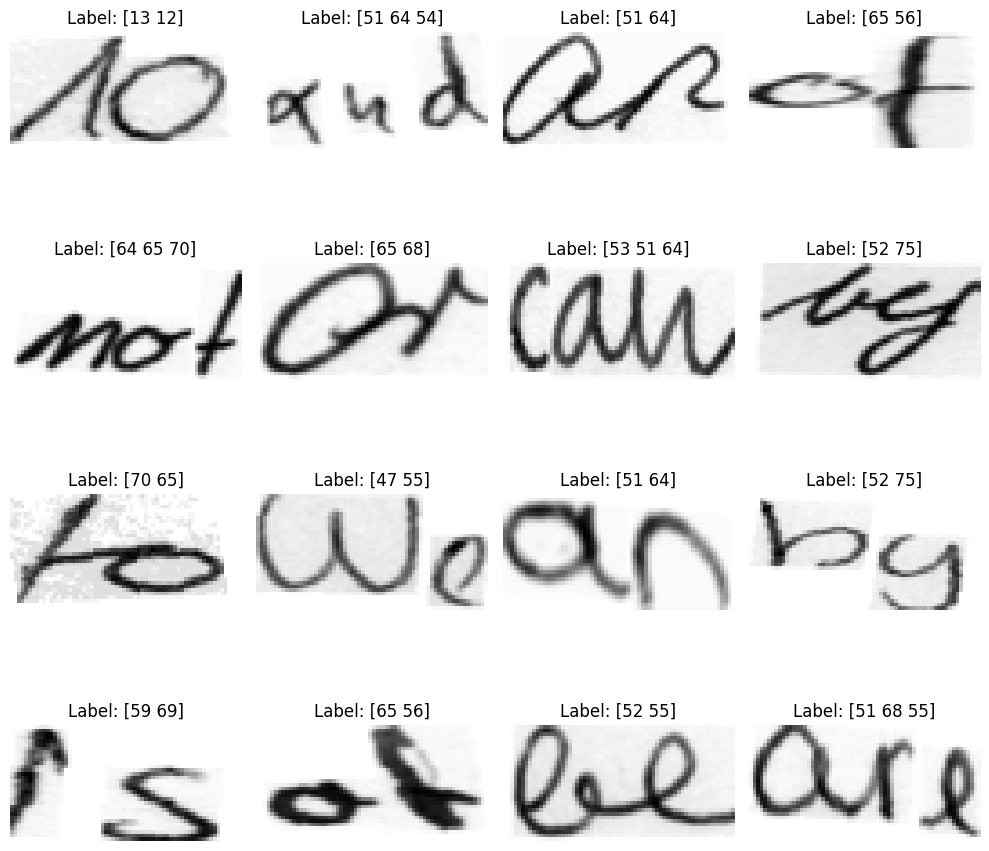

In [113]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (x, y, tl) in enumerate(HandWritingDataset(df.sample(16), augument=True)):
    ax = axes[i // 4, i % 4]
    ax.imshow(x.squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {np.round(y.cpu().numpy(), 2)}")
plt.tight_layout()
plt.show()

# Loader

In [114]:
BATCH_SIZE = 4

def collate_fn(batch):
    images, labels, target_lengths = zip(*batch)

    # Stack images into a batch tensor
    images = torch.stack(images)  # Shape: [batch_size, 1, height, width]

    # Flatten and concatenate labels into a single 1D tensor
    labels = torch.tensor(
        [char for label in labels for char in label], dtype=torch.long).to(device)

    # Convert target_lengths to a tensor
    target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)

    return images, labels, target_lengths


train_dataset = HandWritingDataset(df_train, augument=True)
test_dataset = HandWritingDataset(df_test)
val_dataset = HandWritingDataset(df_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataset[0][0].shape)

torch.Size([1, 32, 64])


# Model

In [115]:
class HandWritingModel(nn.Module):
    def __init__(self):
        super(HandWritingModel, self).__init__()

        self.input_layer = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2), padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(1,4), stride=(1,4), padding=0)
        self.lstm = nn.LSTM(input_size=16*32, hidden_size=128, num_layers=1, batch_first=True)
        self.output = nn.Linear(128, len(vocab))

        self._init_weights()

    def forward(self, x):
        # print(f'input: {x.shape}')
        x = self.input_layer(x)
        x = self.conv1(x)
        # print(f'conv: {x.shape}')
        x = self.pool1(x)
        # print(f'pool1: {x.shape}')
        x = self.conv2(x)
        # print(f'conv: {x.shape}')
        x = self.pool2(x)
        # print(f'pool2: {x.shape}')
        x = x.permute(0, 3, 2, 1)
        # print(f'permute: {x.shape}')
        x = x.flatten(start_dim=2)
        # print(f'flatten: {x.shape}')
        x, (_, _) = self.lstm(x)
        # print(f'lstm: {x.shape}')
        x = x.permute(1, 0, 2)
        # print(f'permute: {x.shape}')
        x = self.output(x)
        x = F.log_softmax(x, dim=2)
        # print(f'output: {x.shape}')
        return x
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Training

In [126]:
model = HandWritingModel().to(device)
criterion = nn.CTCLoss(blank=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
print(model.modules())

epochs = 20
for epoch in range(epochs):
    losses = 0
    i = 0
    for x, y, target_lengths in train_loader:
        optimizer.zero_grad()
        y_pred = model(x)
        # print(y_pred.shape)
        # print(y.shape)
        batch_size = x.size(0)
        input_lengths = torch.full(size=(batch_size,), fill_value=y_pred.size(0), dtype=torch.long).to(device)
        # print(input_lengths)
        loss = criterion(y_pred, y.squeeze(0), input_lengths, target_lengths)
        # print(loss)
        losses += loss.sum().item()
        loss.backward()
        optimizer.step()
        if i % (len(train_dataset) // (BATCH_SIZE * 100)) == 0:
            print('-', end='')
        i += 1
        # print(y)
        # print(y_pred)
    #     break
    # break
    print(f" Epoch {epoch+1}/{epochs}, Loss: {losses/len(train_loader)}")

<generator object Module.modules at 0x742eb6030ad0>
---------------------------------------------------------------------------------------------------- Epoch 1/20, Loss: 3.598783631324768
---------------------------------------------------------------------------------------------------- Epoch 2/20, Loss: 3.1886325168609617
---------------------------------------------------------------------------------------------------- Epoch 3/20, Loss: 3.0708876836299894
---------------------------------------------------------------------------------------------------- Epoch 4/20, Loss: 2.7886138027906417
---------------------------------------------------------------------------------------------------- Epoch 5/20, Loss: 2.5768683421611787
---------------------------------------------------------------------------------------------------- Epoch 6/20, Loss: 2.425243645310402
---------------------------------------------------------------------------------------------------- Epoch 7/20, Loss: 2.3

In [129]:
model.eval()
# loader = DataLoader(HandWritingDataset(df_train[:40]))
loader = test_loader
with torch.no_grad():
    for x, y, tl in loader:
        y_pred = model(x)
        for i in range(y_pred.shape[1]):
            # pred = y_pred[:, i, :].argmax(dim=1)
            print(f'`{''.join([HandWritingDataset.index_to_char[j] for j in y_pred[:, i, :].argmax(dim=1).cpu().numpy() if j != 0])}`')

`Tn`
`the`
`to`
`of`
`tn`
`thr`
`Iy`
`io`
`op`
`oo`
`hhe`
`is`
`of`
`in`
`as`
`hhe`
`ohe`
`of`
`is`
`to`
`on`
`by`
`tn`
`the`
`toe`
`on`
`on`
`the`
`ao`
`thr`
`bee`
`and`
`tre`
`toe`
`of`
`asr`
`ar`
`the`
`an`
`to`
`ths`
`the`
`hes`
`the`
`iee`
`tae`
`th`
`in`
`aoe`
`aae`
`in`
`wad`
`ts`
`his`
`is`
`thw`
`we`
`has`
`the`
`oe`
`an`
`tf`
`is`
`of`
`af`
`ie`
`ir.`
`and`
`ths`
`in`
`ood`
`at`
`by`
`as`
`aae`
`ty`
`toe`
`byy`
`in`
`hn`
`is`
`is`
`ahe`
`to`
`bae`
`ah`
`waw`
`bf`
`are`
`hae`
`the`
`of`
`aoe`
`ie`
`in`
`and`
`aae`
`os`
`ths`
`of`
